Some interesting questions that can be answered using this dataset are:

1. Which apps are most reviewed? Of those, which ones have the highest rating, let's say the top 10?

2. 

### Dataset Context

The applications -or *apps*- offered in the Google Play store are in the millions and growing. As of the writing of this project, the Google Play store is estimated to hold 2.6 million applications. The creator of this dataset, Lavanya Gupta, was able to obtain data on 10,000 of these apps.

She obtained the dataset through scraping the store, which uses dynamic page loading. Dynamic page loading means that the store page displays the apps based on what Google knows about the user requesting the page. And scraping means that she wrote a script that runs through the dynamically-loaded page, reads the data, and outputs it into a structured file, such as the csv file I will be working with for this project.

The data files include another file containing a sentiment analysis conducted on this sample of Google Play apps using the nltk Python library, which stands for Natural Language Toolkit. The objective of this analysis is to try to understand user reviews and what they convey about their opinions of these apps. 

### Dataset Content

#### A. googleplaystore.csv

This file contains the main dataset. It has 10,841 rows of data with the following columns:

*App Category*: Category of the app. This could be beauty, business, entertainment, education...etc.

*Rating*: How users rate the app out of 5, with 1 being the lowest rating and 5 being the highest.

*Reviews*: The number of user reviews each app has received.

*Size*: The memory size needed to install the application.

*Installs*: The number of times each application has been installed by users.

*Type*: Whether the app is free or a paid app.

*Price*: The price of the app.

*Content Rating*: This column specifies the intended audience for the app. Can be for teens, mature audience, or everyone.

*Genres*: The sub-category for each app. Example: for the Education category, this could be Education: Pretend Play.

*Last Updated*: Release date of the most recent update for the app.

*Current Ver*: The app's current version.

*Android Ver*: The oldest version of Android OS supported by the app.


#### B. googleplaystore_user_reviews.csv

This file contains the result of the sentiment analysis conducted by the dataset creator. It has 64,295 rows of data with the following columns:

*App* : Name of the app.

*Translated_Review*: Either the original review in English, or a translated version if the orignal review is in another language.

*Sentiment*: The result of the sentiment analysis conducted on a review. The value is either Positive, Neutral, or Negative.

*Sentiment_Polarity*: A value indicating the positivity or negativity of the sentiment, values range from -1 (most negative) to 1 (most positive).

*Sentiment_Subjectivity*: A value from 0 to 1 indicating the subjectivity of the review. Lower values indicate the review is based on factual information, and higher values indicate the review is based on personal or public opinions or judgements.

### Summary of Limitations

The limitations of the Google Play Store Apps data are:

1. The apps included are relevant to the dataset creator's activity on Google-related sites. She is a Machine Learning Software Developer based in India. It is most likely the applications generated are based on their popularity in the geographical region around India, while this analysis is intended for audience in the U.S or North America.


2. With cloud-based storage available for Android users at little or no cost, app size may have no significant contribution to app popularity. Therefore the *Size* column will be removed.


3. I am not sure if apps follow the same software versioning process, therefore I will assume the *Current Ver* column will be irrelevant to this analysis. Otherwise it would have been useful for measuring current support of the app by its developers.


4. I will assume that the vast majority of users can upgrade their Android devices to the latest version. Based on that, the *Android Ver* column will also be excluded. Any limitations that may justify relying on older versions of Android most probably do not apply to the majority of the population.


5. Scraping data off of a Google website is an unconventional way to obtain it, which may result in misplaced data. This largely depends on the scraper built by the dataset creator.


6. The sentiment analysis result is limited by the abilities of Python's nltk library, which does not support all languages. Reviews with unsupported languages will not be translated and should have no values within the analysis output.

I will start by importing the csv files into two Pandas dataframes, one called *app_data* which contains the main data on the applications, and another called *sentiment_data* containing the sentiment analysis results on app reviews.

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [179]:
#Import the googleplaystore.csv into a Pandas dataframe
app_data = pd.read_csv(r"C:\Users\Mohammad\Documents\Thinkful\7.11 Capstone 1 Analytic Report and Research Proposal\google-play-store-apps\googleplaystore.csv")

#Show the first 3 rows of the dataframe
app_data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


The rows are in their original sorting order. While the most popular apps are would still be most popular according to India and Lavanya's user behavior, I am confident they are still recognizable by North American audience due to their global offering:

In [180]:
# Sort the original dataset by number of installs to see most popular apps first
app_data = app_data.sort_values(by="Installs", ascending=False)
app_data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN
420,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17714850,40M,"500,000,000+",Free,0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up
474,LINE: Free Calls & Messages,COMMUNICATION,4.2,10790289,Varies with device,"500,000,000+",Free,0,Everyone,Communication,"July 26, 2018",Varies with device,Varies with device


*Life Made WI-Fi Touchscreen Photo Frame* is listed in the top, but is not a result of a huge amount of installs. This is probably due to an error in data entry that is attributed to the scraper used to get this dataset. However it is good that only one erroneous row exists beyond the true most-installed app rows. Since erroneous rows are likely to exist outside the range of [0, maximum value] it is a must to check if such rows exist beyond rows with 0 installs as well:

In [181]:
#re-sort the data in ascending order to show least installed apps first
app_data = app_data.sort_values(by="Installs")
app_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device
9337,EG | Explore Folegandros,TRAVEL_AND_LOCAL,NaN,0,56M,0+,Paid,$3.99,Everyone,Travel & Local,"January 22, 2017",1.1.1,4.1 and up
9719,EP Cook Book,MEDICAL,NaN,0,3.2M,0+,Paid,$200.00,Everyone,Medical,"July 26, 2015",1.0,3.0 and up
6692,cronometra-br,PRODUCTIVITY,NaN,0,5.4M,0+,Paid,$154.99,Everyone,Productivity,"November 24, 2017",1.0.0,4.1 and up
8081,CX Network,BUSINESS,NaN,0,10M,0+,Free,0,Everyone,Business,"August 6, 2018",1.3.1,4.1 and up


This is good news, no erroneous rows exist below 0 for the *Installs* column. Therefore all we have to do is delete
that one erroneous row. I will proceed to drop it, plus the *Size*, *Current Ver*, and the *Andoird Ver* columns from the dataset. Note that the erroneous row's index is **10472**, which will be used as the argument to drop the row:

In [182]:
#re-sort the data with most installed apps first
app_data = app_data.sort_values(by="Installs", ascending=False)

#remove the erroneous row from the original dataset, using its index
app_data = app_data.drop(10472, axis=0)

#remove unusable columns
app_data = app_data.drop(columns=["Size", "Current Ver","Android Ver"])

app_data.head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated
1661,Temple Run 2,GAME,4.3,8118609,"500,000,000+",Free,0,Everyone,Action,"July 5, 2018"
474,LINE: Free Calls & Messages,COMMUNICATION,4.2,10790289,"500,000,000+",Free,0,Everyone,Communication,"July 26, 2018"
3574,Cloud Print,PRODUCTIVITY,4.1,282460,"500,000,000+",Free,0,Everyone,Productivity,"May 23, 2018"
3326,Gboard - the Google Keyboard,TOOLS,4.2,1859109,"500,000,000+",Free,0,Everyone,Tools,"July 31, 2018"
431,Viber Messenger,COMMUNICATION,4.3,11334973,"500,000,000+",Free,0,Everyone,Communication,"July 18, 2018"


### 1. Which apps are most reviewed? Of those, which ones have the highest rating, let's say the top 10?

To proceed in answering the first part of our first question *What apps are most reviewed?*, it is logical to assume the most installed apps have the most reviews, in this case these are apps with over 500 million installs. For purposes of our analysis, we will call them *famous apps*. First I will parse *Install* values to integers, then do a log transformation to get rid of the trailing zeros. Before doing that, I will save the original bin values as names for plotting purposes:

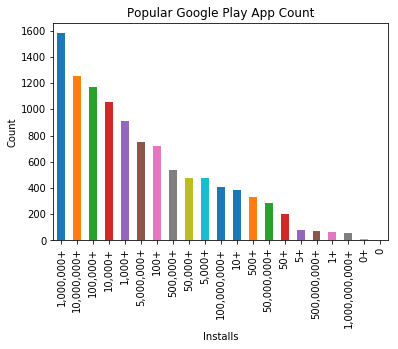

In [185]:
app_data["Installs"].value_counts().plot(kind='bar')
plt.title("Popular Google Play App Count")
plt.ylabel("Count")
plt.xlabel("Installs")
plt.show()


# install_bins = pd.DataFrame()
# (bins, counts) = np.unique(app_data['Installs'], return_counts=True)
# bins = [int(value.replace("+","").replace(",","")) for value in bins]
# install_bins['bins'] = bins
# install_bins['counts'] = counts
# install_bins = install_bins.sort_values(by = "bins",ascending=False)
# install_bins.groupby("bins")

# def Textualize_bins(series):
#     """ Takes in a number that is a multiple of a thosand, million, or billion and converts to words such as 1 Million
#     """
#     text_bins = []
#     for amount in bins:
#         amount = str(amount)
#         if amount.endswith("0"*9):
#             amount = amount.replace("0"*9," Billion")
#         elif amount.endswith("0"*6):
#             amount = amount[:-6]+ amount[-6:].replace("0"*6," Million")
#         elif amount.endswith("0"*3):
#             amount = amount[:-3] + "," +amount[-3:]
#         text_bins.append(amount)
#     series = pd.Series(text_bins)
#     return series
        
# install_bins['bins'] = Textualize_bins(install_bins['bins'])



# .hist()
# plt.show()

# # Does this need to be a function? I do not think so because it is only used once.

# integerized = []

# for value in app_data["Installs"]:
    
#     #Remove the + sign from end of value
#     value = value.replace("+","")

#     #Remove the commas used as thousand-separators, then parse the number to integer
#     value = int(value.replace(",",""))
    
#     integerized.append(value)

# #Parse number of reviews to integers
# app_data["Reviews"] = [int(value) for value in app_data["Reviews"]]


# #Log-transform Installs and Reviews
# app_data["Reviews"] = [np.log(value) for value in app_data["Reviews"]]
# app_data["Installs"] = [np.log(value) for value in pd.Series(integerized)]

# del integerized
# app_data.head()

Now to see the most reviewed apps. We know that the likeliness of reviewing an app increases with the number of installs, we also know that some app developers like to hire fake review services to boost their app's placing in the market. This is important since I will be comparing app reviews based on a ratio that I will call *Review Ratio*, which is calculated using the formula: 

$$Review Ratio = \frac {Reviews}{Installs}$$

Going back to fake reviews. If a developer just hired a service to review a recently introduced app with 0 installs, the value of the *Review Ratio* should be infinite since any number of reviews posted will be divided by 0. Numpy labels such values as *inf*, and they will likely show on top of the apps with actual highest *Review Ratio*, therefore they will be replaced with Numpy's *NaN* values, and then removed using the Pandas *pd.dropna()* function:

In [90]:
# #add a new column containing review ratios
# app_data["ReviewRatio"] = app_data["Reviews"]/app_data["Installs"]

# #Remove rows with usesless values
# app_data = app_data.replace([np.inf, -np.inf], np.nan)
# app_data.dropna()

app_data = app_data.sort_values(by="Installs", ascending=False)
app_data.head()



,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated
8233,DB Busradar NRW,MAPS_AND_NAVIGATION,3.7,78,1.000000e+09,Free,0,Everyone,Maps & Navigation,"April 12, 2017"
8229,DB Event App,SOCIAL,2.4,37,1.000000e+09,Free,0,Teen,Social,"June 25, 2017"
8266,DC Universe Online Map,TOOLS,4.1,1186,1.000000e+09,Free,0,Unrated,Tools,"February 27, 2012"
8251,LEGO Batman: DC Super Heroes,FAMILY,4.2,2557,1.000000e+09,Paid,$4.99,Everyone 10+,Adventure;Action & Adventure,"May 9, 2016"
8270,Villains vs Superheroes,FAMILY,4.3,128,1.000000e+09,Free,0,Everyone,Puzzle,"September 12, 2017"


Next, I will import the *googleplaystore_user_reviews* csv file into a dataframe named *sentiment_data*. Then I will proceed to remove all rows where the analysis does not have results. Only before that I want to have an idea of how many reviews were not translated: